# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
Инструкция по выполнению проекта
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [ ]:
print(labels.info())
print()
print(labels.describe())
print()
print(labels.isnull().sum())
print()
print(labels.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

file_name    0
real_age     0
dtype: int64

0


В датасете две колонки: фотографии людей и их возраст, всего 7591 строка, стреднее значение по колонке с возрастом 31, построим график распределения возраста для понимания общей картины. 

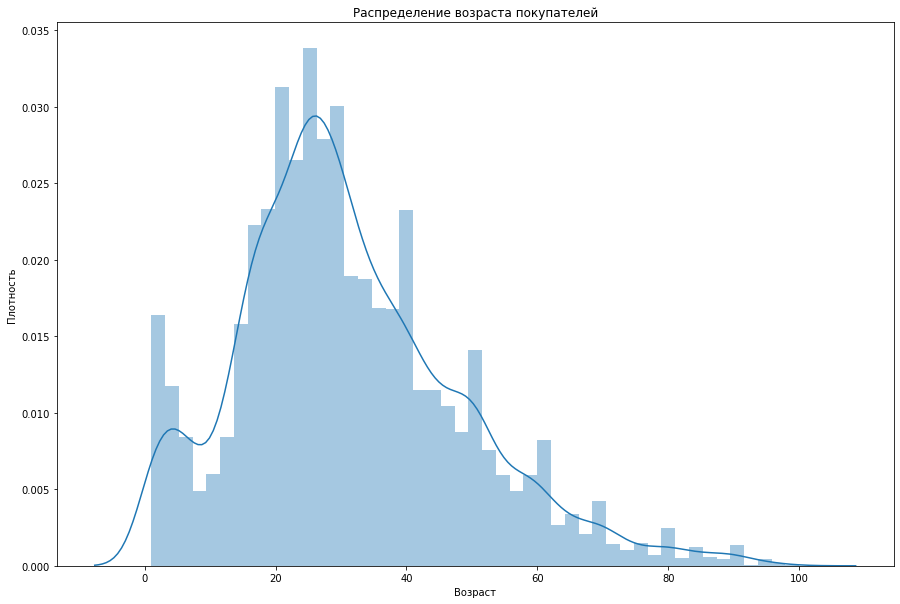

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(labels['real_age'])
plt.title('Распределение возраста покупателей')
plt.xlabel('Возраст')
plt.ylabel('Плотность');

По графику видно, что основная часть фотографий людей возраста 25-35 лет, также есть достаточное количество фотографий детей годовалого возраста и людей в возрасте 40 лет. Теперь изучим сами изображения.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1 / 255)

train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels,
                                                       directory='/datasets/faces/final_files/',
                                                       x_col="file_name", 
                                                       y_col="real_age",
                                                       class_mode="raw",
                                                       target_size=(224,224),  
                                                       batch_size=32,
                                                       seed=12345)

Found 7591 validated image filenames.


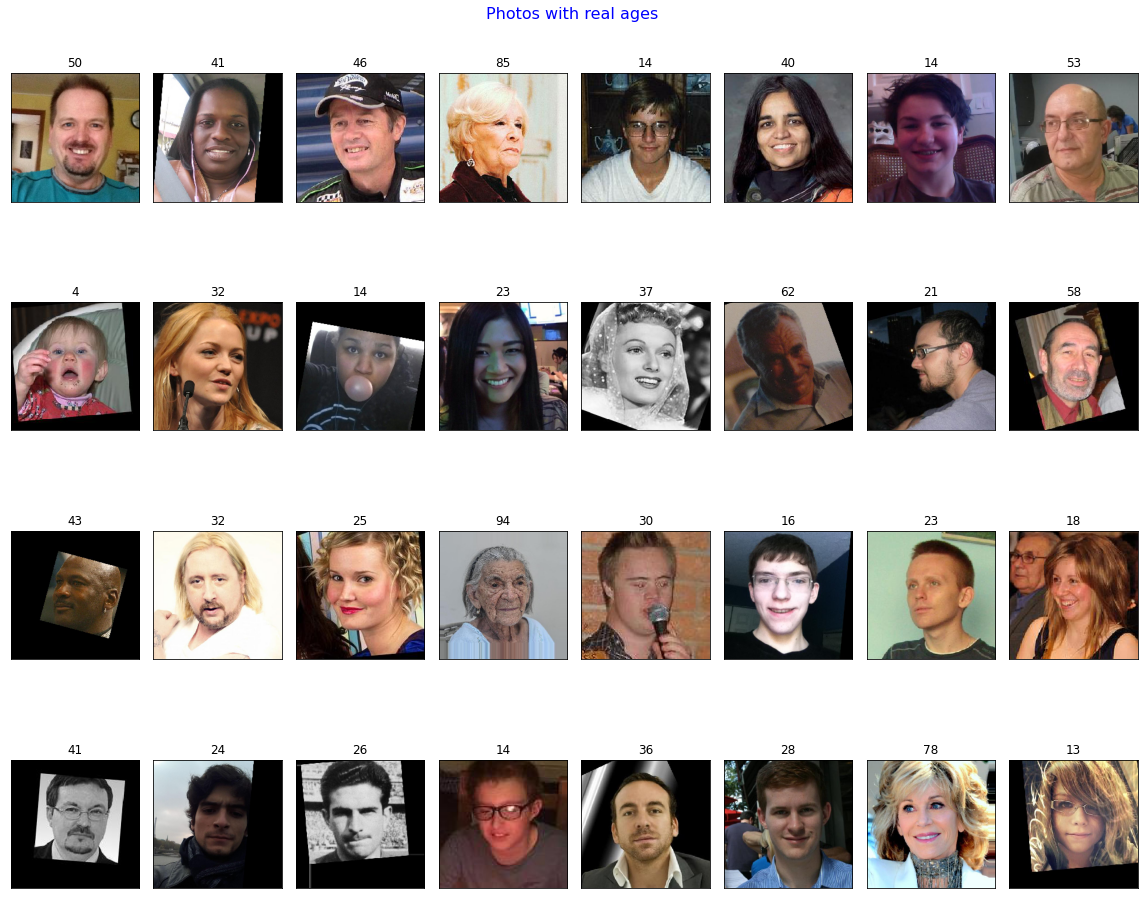

In [ ]:
features, target = next(train_datagen_flow)

# Выведем фотографии
fig = plt.figure(figsize=(16,16))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

В датасете представлены разные фотографии с разным качеством, а также сдвинутые. Перевернутые и смещенные фотографии должны позволить модели лучше определять возраст и избежать переобучения. Перейдем к обучению.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
2023-04-29 14:01:18.284651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-29 14:01:18.663901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
Epoch 2/15
356/356 - 74s - loss: 189.7036 - mae: 10.3164 - val_loss: 480.0168 - val_mae: 16.8258
356/356 - 46s - loss: 94.8840 - mae: 7.4276 - val_loss: 136.5949 - val_mae: 8.9631
Epoch 3/15
356/356 - 47s - loss: 58.8026 - mae: 5.8627 - val_loss: 85.0853 - val_mae: 6.9823
Epoch 4/15
356/356 - 47s - loss: 38.9309 - mae: 4.8381 - val_loss: 88.2112 - val_mae: 7.2069
Epoch 5/15
356/356 - 46s - loss: 23.8756 - mae: 3.7885 - val_loss: 85.7523 - val_mae: 7.0854
Epoch 6/15
356/356 - 47s - loss: 19.5030 - mae: 3.3741 - val_loss: 72.2410 - val_mae: 6.3781
Epoch 7/15
356/356 - 45s - loss: 16.3264 - mae: 3.0919 - val_loss: 86.6247 - val_mae: 7.0374
Epoch 8/15
356/356 - 44s - loss: 14.3687 - mae: 2.8964 - val_loss: 88.0709 - val_mae: 7.1433
Epoch 9/15
356/356 - 49s - loss: 13.8124 - mae: 2.8566 - val_loss: 91.6777 - val_mae: 7.1925
Epoch 10/15
356/356 - 43s - loss: 13.2809 - mae: 2.8012 - val_loss: 79.4601 - val_mae: 6.7782
Epoch 11/15
356/356 - 41s - loss: 13.4149 - mae: 2.8223 - val_loss: 91.2498 - val_mae: 7.5051
Epoch 12/15
356/356 - 41s - loss: 12.9163 - mae: 2.7636 - val_loss: 75.0829 - val_mae: 6.4711
Epoch 13/15
356/356 - 41s - loss: 45.8574 - mae: 5.0944 - val_loss: 155.2183 - val_mae: 9.2360
Epoch 14/15
Epoch 15/15
356/356 - 40s - loss: 30.8762 - mae: 4.2312 - val_loss: 86.7572 - val_mae: 6.9634
356/356 - 40s - loss: 11.9216 - mae: 2.6271 - val_loss: 77.2879 - val_mae: 6.5450
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 77.2879 - mae: 6.5450
Test MAE: 6.5450
```

## Анализ обученной модели

* Исследовательский анализ данных показал, что средний возраст обучающей выборки около 30 лет, фотографии имеют разное масштабирование и качество, поэтому нейросеть должна хорошо обучаться.   

* За основу нейросети была взята архитектура ResNet50, learning rate 0.0003, 15 эпох.

* Абсолютная ошибка среднего получилась равной **6.54**, что является очень хорошим результатом. 

Полученная модель соответствует поставленной задаче и может использоваться для анализа покупок клиентов и предложения релевантных товаров, а также для контроля добросовестности кассиров при продаже алкоголя.